
NLP From Scratch: Translation with a Sequence to Sequence Network


This is the third project, where we write our own classes and functions to preprocess 
the data to do our NLP modeling tasks. 

In this project we will be teaching a neural network to translate from
French to English.


    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau.
    = he is painting a picture.
    < he is painting a picture.

    > pourquoi ne pas essayer ce vin delicieux?
    = why not try that delicious wine?
    < why not try that delicious wine?

    > elle n est pas poete mais romanciere.
    = she is not a poet but a novelist.
    < she not not a poet but a novelist.

    > vous etes trop maigre.
    = you re too skinny.
    < you re all alone.

to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](<https://arxiv.org/abs/1409.3215>), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

![jupyter](./pictures/seq2seq.png)


**Recommended Reading:**

We assume you have installed PyTorch, know Python, and
understand Tensors in project 1.

It would also be useful to know about Sequence to Sequence networks and
how they work:

-  [Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation](<https://arxiv.org/abs/1406.1078>)

-  [Sequence to Sequence Learning with Neural
   Networks](<https://arxiv.org/abs/1409.3215>)
   
-  [Neural Machine Translation by Jointly Learning to Align and
   Translate](<https://arxiv.org/abs/1409.0473>)

-  [A Neural Conversational Model](<https://arxiv.org/abs/1506.05869>)

**Requirements:**



In [1]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

[This question on Open Data Stack
Exchange](<https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>)
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

                                        I am cold.    J'ai froid.

Note:
   Download the data from
   [here](<https://download.pytorch.org/tutorial/data.zip>)
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

![jupyter](./pictures\word-encoding.png)





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        #按空格划分句子得到word，通过调用self.addWord()函数将word加入到字典映射中
        #######Your Code#######
        words = sentence.split(' ')
        for word in words:
            self.addWord(word)

        #######End#######

    def addWord(self, word):
        if word not in self.word2index:
            # 构建两个字典self.word2index和self.index2word，完成【word到对应数字】和【数字到word】的映射，并记录每个word出现的次数
            #######Your Code#######
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1

            #######End#######
            
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 39365 sentence pairs
Trimmed to 1271 sentence pairs
Counting words...
Counted words:
fra 1418
eng 1093
['tu compares des choux et des carottes !', 'you re comparing apples and oranges !']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](<https://arxiv.org/abs/1409.3215>), or
seq2seq network, or
[Encoder Decoder network](<https://arxiv.org/pdf/1406.1078v3.pdf>), is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

![jupyter](./pictures/seq2seq.png)


Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.


![jupyter](./pictures/encoder-network.png)

In order for the model to exhibit satisfactory results, we replaced the 
RNN with GRU, which is a variant of RNN. The difference with RNN is the 
way the states and outputs are calculated. Now we show the difference between
RNN(Recurrent Neural Networks) and GRU(Gated Recurrent Units).

### RNN(Recurrent Neural Networks)

![jupyter](./pictures/RNN.png)

At each time step t, we calculate hidden state $s_t$ and $o_t$ output by the following formula:


<center>$s_t = Ux_t+Vs_{t-1}$</center>

<center>$o_t = W(Ux_t+Vs_{t-1}) = Ws_t$</center>


### GRU(Gated Recurrent Units)

![jupyter](./pictures/GRU.png)

For GRU, we calculate it by the following equation：

<center>$z_t = W_z·[s_{t-1},x_t]$</center>

<center>$r_t = W_r·[s_{t-1},x_t]$</center>

<center>$\widetilde{s}_t = W·[r_t*s_{t-1},x_t]$</center>

<center>$s_t = (1-z_t)*s_{t-1}+z_t*\widetilde{s}_t$</center>

<center>$o_t = Ws_t$</center>

where $z_t$ is update gate, $r_t$ is reset gate, $r_t$ indicates how much information is retained about the past, $z_t$ weights the past information and $s_{t-1}$ to get the hidden state $s_t$. Similarly we get output $o_t$ by $s_t$.


In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)

    def forward(self, input, hidden):
        
        # 合理调用__init__()函数中声明的函数，来完成Encoder RNN的一个time step计算过程
        #######Your Code#######
        
        # 使用self.embedding将输入转化为向量表达
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded

        # 调用self.rnn计算当前时间步的hidden state和output并返回
        output, hidden = self.rnn(output, hidden)

        return output, hidden
        
        #######End#######


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




"Simple Decoder"


In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

![jupyter](./pictures/decoder-network.png)






In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        # 合理调用__init__()函数中声明的函数，来完成Decoder RNN的一个time step的计算过程
        #######Your Code#######
        
        # 使用self.embedding将输入转化为向量表达,对于decoder，可以对该输出使用激活函数（如：F.relu）
        embedded = self.embedding(input).view(1, 1, -1)
        
        # 调用self.rnn计算当前时间步的hidden state和output
        hidden, output = self.rnn(embedded, hidden)
        
        # 使用self.softmax计算output概率分布
        output = self.softmax(self.out(output[0]))
        
        # return output&hidden state
        return output, hidden
        
        #######End#######


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but 

[when the trained
network is exploited, it may exhibit
instability](<http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf>)

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.


In [10]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        # 完成训练部分代码
        #######Your Code#######
        
        # 调用encoder类完成整个编码计算流程
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
        #######End#######
        
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    for di in range(target_length):
        # 完成训练部分代码
        #######Your Code#######
        
        # 调用decoder类完成整个解码计算流程
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        
        # 计算解码器每个time step prediction和target的loss，进行求和得到最终loss
        loss += criterion(decoder_output, target_tensor[di])
        
        #######End#######
        
        decoder_input = target_tensor[di]


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [12]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = tensorsFromPair(random.choice(pairs))

    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss().to(device)

    for iter in range(1, n_iters + 1):
        
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder,
        decoder, encoder_optimizer, decoder_optimizer, criterion)
        

        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there.

In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [15]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single RNN layer. After about ``40 minutes`` on a ``CPU`` we'll get some
reasonable results.

Note:
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




0m 55s (- 9m 16s) (5000 9%) 2.0496
1m 48s (- 8m 7s) (10000 18%) 1.0663
2m 45s (- 7m 21s) (15000 27%) 0.8000
3m 41s (- 6m 28s) (20000 36%) 0.6651
4m 34s (- 5m 29s) (25000 45%) 0.5574
5m 25s (- 4m 31s) (30000 54%) 0.4972
6m 19s (- 3m 36s) (35000 63%) 0.4344
7m 13s (- 2m 42s) (40000 72%) 0.3843
8m 6s (- 1m 48s) (45000 81%) 0.3530
9m 1s (- 0m 54s) (50000 90%) 0.3160
9m 54s (- 0m 0s) (55000 100%) 0.2962


<Figure size 640x480 with 0 Axes>

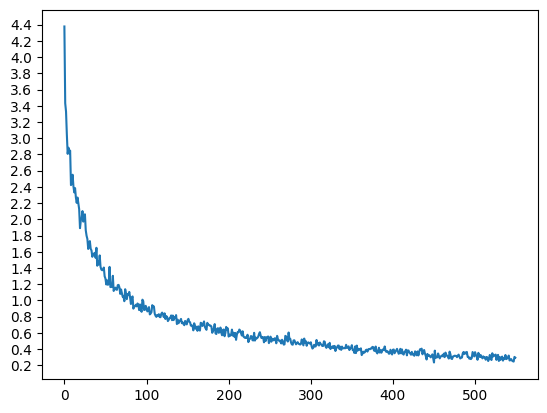

In [16]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 55000, print_every=5000)

In [17]:
evaluateRandomly(encoder1, decoder1)

> tu n es pas si interessant .
= you re not that interesting .
< you re not that interesting . <EOS>

> je vais preparer a diner .
= i m going to fix some dinner .
< i m going to buy some bread . <EOS>

> elle est l editeur en chef .
= she is the editor in chief .
< she is the executive editor . <EOS>

> nous n allons pas le jeter .
= we re not throwing it away .
< we re going to do everything we can . <EOS>

> je me trouve dans une situation desesperee .
= i m in a desperate situation .
< i m confused enough as it is . <EOS>

> je suis desolee a propos de hier soir .
= i m sorry about last night .
< i m sorry about last night . <EOS>

> tu n es pas aussi maligne que moi .
= you re not as smart as me .
< you re not as smart as me . <EOS>

> j oublie toujours les noms des gens .
= i m always forgetting people s names .
< i m always forgetting people s names . <EOS>

> vous ne trompez personne .
= you re not fooling anybody .
< you re very sophisticated . <EOS>

> ceci m est indifferent 

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Attention Mechanism
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


